# Initial code

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys 
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.decomposition import PCA

sys.path.append(os.path.abspath("/home/dferri/ipremom/model/v45/tg-cfrna-modeling-totrna"))

from src.utils.cfRNA_utils import build_counts_matrix, compute_logFC, compute_timeStats

In [3]:
LOPE_samples = [
    "C02-P0016", "C03-P0039", "C03-P0044", "C03-P0052", "C03-P0129", 
    "C03-P0131", "C03-P0239", "C03-P0632", "C03-P0768", "C03-P0779", 
    "C04-P0106", "C05-P0305", "C05-P0447", "C06-P0064", "C09-P0246", 
    "C09-P0400", "C09-P0405", "C09-P0465", "C09-P0857", "C09-P0858", 
    "C09-P0891", "C09-P0940", "C09-P0941", "C11-P0025", "C12-P0049", 
    "C12-P0164", "C12-P0182", "C12-P0324", "C12-P0348", "C12-P0538", 
    "C20-P0317", "C20-P0528", "C20-P0864", "C20-P1003", "C20-P1094", 
    "C21-P0197", "C21-P0600", "C12-P0231", "C05-P1379", "C12-P0447", 
    "C20-P0815", "C21-P0583", "C21-P1237"
]

EOPE_samples = [
    "C03-P0041", "C03-P0190", "C03-P0290", "C03-P0356", "C03-P0428",
    "C03-P0470", "C03-P0592", "C03-P0702", "C03-P0911", "C04-P0118",
    "C04-P0189", "C05-P0151", "C05-P0699", "C05-P0940", "C09-P0082",
    "C09-P0329", "C09-P0649", "C09-P0798", "C09-P0950", "C09-P1069",
    "C10-P0130", "C11-P0039", "C12-P0033", "C12-P0067", "C12-P0114",
    "C12-P0323", "C12-P0520", "C20-P0126", "C20-P0144", "C20-P0302",
    "C20-P0534", "C21-P0447", "C21-P0849", "C21-P0867", "C21-P0962",
    "C04-P0412", "C21-P0890", "C05-P2079", "C04-P0228", "C20-P0951",
    "C20-P0999", "C06-P0069"
]

control_samples = [
    "C02-P0039", "C03-P0708", "C03-P0757", "C03-P0807", "C05-P0002",
    "C05-P0050", "C05-P0066", "C05-P0132", "C05-P0166", "C05-P0237",
    "C05-P0260", "C05-P0375", "C05-P0987", "C05-P1665", "C05-P1671",
    "C05-P1682", "C05-P1718", "C05-P1728", "C05-P1736", "C09-P0015",
    "C09-P0153", "C10-P0014", "C10-P0015", "C12-P0012", "C12-P0078",
    "C12-P0110", "C12-P0210", "C12-P0232", "C12-P0419", "C12-P0440",
    "C20-P0176", "C20-P0638", "C20-P0646", "C20-P0654", "C20-P0698",
    "C20-P1178", "C05-P1759", "C12-P0552", "C05-P2099", "C03-P0743",
    "C03-P0026", "C03-P0045", "C02-P0013", "C03-P0007", "C03-P0024",
    "C03-P0037", "C03-P0046", "C03-P0047", "C03-P0157", "C03-P0168",
    "C03-P0205", "C05-P0010", "C05-P0253", "C09-P0010", "C09-P0100",
    "C09-P0228", "C09-P0237", "C09-P0712", "C12-P0043", "C12-P0051",
    "C12-P0108", "C12-P0209", "C12-P0295", "C12-P0373", "C20-P0797",
    "C20-P0183", "C03-P0008", "C12-P0122", "C05-P0725", "C05-P0045",
    "C06-P0019", "C03-P0447", "C05-P0847", "C12-P0090", "C12-P0314"
]

dict_types_samples = {"LOPE": LOPE_samples,
                      "EOPE": EOPE_samples,
                      "Control": control_samples}


# Figure rRNA fraction

In [ ]:
# Define timepoints
timepoints = ['T1', 'T2', 'T3']

# Base path where the different runs are stored
base_folder = "/home/iperez/Documents/Projects/Preeclampsia/Data/data_v45"

# List all runs in the base folder
runs = os.listdir(base_folder)
runs.remove("MOM-PO02")  # Exclude a specific run

# Initialize a DataFrame to store all results
all_rRNA_results = pd.DataFrame(columns=['sample', 'timepoint', 'group', 'rRNA_fraction', 'run'])

# Iterate over all directories in the base folder (which correspond to runs)
for run_folder in tqdm(runs):
    run_path = os.path.join(base_folder, run_folder)
    
    if os.path.isdir(run_path):
        print(f"Processing run: {run_folder}")
        
        # Define paths for duplicated and deduplicated count files
        folder_dup = os.path.join(run_path, "counts/")
        folder_dedup = os.path.join(run_path, "counts_dedup/")
        
        # Use the build_counts_matrix function to get duplicated and deduplicated counts
        dupCounts = build_counts_matrix.build_counts_matrix(folder_dup, sample_pattern=r".*-T[0-9]*")
        dedupCounts = build_counts_matrix.build_counts_matrix(folder_dedup, sample_pattern=r".*-T[0-9]*")
        
        # Set "GeneID" as the index (equivalent to column_to_rownames in R)
        dupCounts.set_index("GeneID", inplace=True)
        dedupCounts.set_index("GeneID", inplace=True)
        
        # Read the 'biotypes.txt' file (fixed path for this file)
        gtfDatabase = pd.read_csv("/home/iperez/Documents/Projects/Preeclampsia/Data/v45biotypes.txt", sep="\t")
        gtfDatabase['GeneID'] = gtfDatabase['gene_name'].fillna(gtfDatabase['gene_ID'])
        
        # Combine dedupCounts with gtfDatabase based on 'GeneID'
        biotype_df = dedupCounts.merge(gtfDatabase, left_on='GeneID', right_on='GeneID', how='left')
        
        # Initialize an empty DataFrame for the results of this run
        plot_df = pd.DataFrame(columns=["gene_type", "counts", "sample", "freq", "label"])

        # Process each sample in dedupCounts
        samples = dedupCounts.columns.tolist()
        
        for s in samples:
            rows2add = (
                biotype_df[['gene_name', s, 'gene_type']]
                .rename(columns={s: 'sample_counts'})
                .groupby('gene_type')['sample_counts'].sum().reset_index()
                .assign(freq=lambda x: round(x['sample_counts'] / x['sample_counts'].sum(), 3))
                .sort_values(by='freq', ascending=False)
                .assign(label=lambda x: (x['freq'] * 100).astype(str) + '%', sample=s)
            )
            plot_df = pd.concat([plot_df, rows2add], ignore_index=True)
        
        # Filter for rRNA gene types
        plot_df['gene_type'] = plot_df['gene_type'].apply(lambda x: 'rRNA' if x in ["Mt_rRNA", "rRNA_pseudogene", "rRNA"] else 'non_rRNA')

        # Group by sample and gene type, summing counts
        rRNA_plot = plot_df.groupby(['sample', 'gene_type']).agg({'sample_counts': 'sum'}).reset_index()

        # Calculate frequency
        rRNA_plot = rRNA_plot.groupby('sample').apply(
            lambda x: x.assign(freq=round(x['sample_counts'] / x['sample_counts'].sum(), 6))
        ).reset_index(drop=True)

        # Filter only the rRNA fraction
        rRNA_plot = rRNA_plot[rRNA_plot['gene_type'] == 'rRNA']

        # Iterate over groups (EOPE, LOPE, Control) and timepoints
        for group, samples_group in dict_types_samples.items():
            for sample in samples_group:
                # Extract the base name of the sample without the '-Tn' suffix
                sample_base = sample.split('-')[0] + "-" + sample.split('-')[1]
                
                # Find corresponding samples in rRNA_plot for T1, T2, and T3
                for timepoint in timepoints:
                    sample_with_timepoint = f"{sample_base}-{timepoint}"
                    
                    if sample_with_timepoint in rRNA_plot['sample'].values:
                        # Filter rRNA data for the current sample and timepoint
                        sample_data = rRNA_plot[rRNA_plot['sample'] == sample_with_timepoint]
                        
                        if not sample_data.empty:
                            rRNA_fraction = sample_data['freq'].values[0]
                        else:
                            rRNA_fraction = 0.0
                        
                        # Add results to the global DataFrame
                        new_row = pd.DataFrame({
                            'sample': [sample_with_timepoint],
                            'timepoint': [timepoint],
                            'group': [group],
                            'rRNA_fraction': [rRNA_fraction],
                            'run': [run_folder]
                        })

                        all_rRNA_results = pd.concat([all_rRNA_results, new_row], ignore_index=True)


# Define a custom color palette
custom_palette = {
    "Control": "#AED6F1",  # Blue
    "EOPE": "#EC7063",  # Red
    "LOPE": "#BB8FCE"  # Purple
}

# Ensure groups are always in the same order: LOPE, EOPE, Control
all_rRNA_results['group'] = pd.Categorical(all_rRNA_results['group'], categories=['EOPE', 'LOPE', 'Control'], ordered=True)

# Generate boxplots for each timepoint
fig, axes = plt.subplots(1, len(timepoints), figsize=(15, 6), sharey=True)

for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    sns.boxplot(x='group', y='rRNA_fraction', data=all_rRNA_results[all_rRNA_results['timepoint'] == timepoint], ax=ax, palette=custom_palette)
    ax.axhline(0.1, ls='--', color='black')  # Horizontal line for rRNA fraction 0.1
    ax.set_title(f'Timepoint {timepoint}')
    ax.set_xlabel('Group')
    if i == 0:
        ax.set_ylabel('rRNA Fraction')
    else:
        ax.set_ylabel('')
    ax.grid()

plt.tight_layout()
plt.suptitle('rRNA Fraction per Timepoint and Group', y=1.02)
plt.show()


  0%|          | 0/27 [00:00<?, ?it/s]

Procesando run: MOM-18v45


  4%|▎         | 1/27 [00:03<01:26,  3.31s/it]

Procesando run: MOM-28v45


  7%|▋         | 2/27 [00:06<01:24,  3.39s/it]

Procesando run: MOM-4v45


 11%|█         | 3/27 [00:10<01:20,  3.34s/it]

Procesando run: MOM-24v45


 15%|█▍        | 4/27 [00:13<01:19,  3.45s/it]

Procesando run: MOM-19v45


 19%|█▊        | 5/27 [00:17<01:15,  3.45s/it]

Procesando run: MOM-22v45


 22%|██▏       | 6/27 [00:20<01:12,  3.45s/it]

Procesando run: MOM-30v45


 26%|██▌       | 7/27 [00:24<01:09,  3.45s/it]

Procesando run: MOM-31v45


 30%|██▉       | 8/27 [00:27<01:05,  3.46s/it]

Procesando run: MOM-17v45


 33%|███▎      | 9/27 [00:30<01:01,  3.43s/it]

Procesando run: MOM-29v45


 37%|███▋      | 10/27 [00:34<00:58,  3.44s/it]

Procesando run: MOM-13v45


 41%|████      | 11/27 [00:37<00:55,  3.46s/it]

Procesando run: MOM-16v45


 44%|████▍     | 12/27 [00:41<00:52,  3.51s/it]

Procesando run: MOM-12v45


 48%|████▊     | 13/27 [00:45<00:49,  3.53s/it]

Procesando run: MOM-6v45


 52%|█████▏    | 14/27 [00:48<00:46,  3.57s/it]

Procesando run: MOM-15v45


 56%|█████▌    | 15/27 [00:52<00:42,  3.57s/it]

Procesando run: MOM-27v45


 59%|█████▉    | 16/27 [00:55<00:39,  3.57s/it]

Procesando run: MOM-9v45


 63%|██████▎   | 17/27 [00:59<00:35,  3.59s/it]

Procesando run: MOM-7v45


 67%|██████▋   | 18/27 [01:02<00:32,  3.57s/it]

Procesando run: MOM-11v45


 70%|███████   | 19/27 [01:06<00:28,  3.58s/it]

Procesando run: MOM-10v45


 74%|███████▍  | 20/27 [01:09<00:24,  3.49s/it]

Procesando run: MOM-14v45


 78%|███████▊  | 21/27 [01:13<00:21,  3.50s/it]

Procesando run: MOM-20v45


 81%|████████▏ | 22/27 [01:16<00:17,  3.52s/it]

Procesando run: MOM-25v45


 85%|████████▌ | 23/27 [01:20<00:14,  3.52s/it]

Procesando run: MOM-8v45


 89%|████████▉ | 24/27 [01:24<00:10,  3.54s/it]

Procesando run: MOM-26v45


 93%|█████████▎| 25/27 [01:27<00:07,  3.54s/it]

Procesando run: MOM-21v45


 96%|█████████▋| 26/27 [01:30<00:03,  3.48s/it]

Procesando run: MOM-23v45


100%|██████████| 27/27 [01:34<00:00,  3.49s/it]


Muestras que superan el umbral de 0.1:
           sample timepoint    group  rRNA_fraction
35   C03-P0131-T2        T2     LOPE       0.102322
38   C03-P0041-T2        T2     EOPE       0.350387
52   C03-P0239-T2        T2     LOPE       0.133746
372  C09-P0100-T2        T2  Control       0.100313
388  C09-P0246-T2        T2     LOPE       0.112357
397  C03-P0205-T2        T2  Control       0.211456


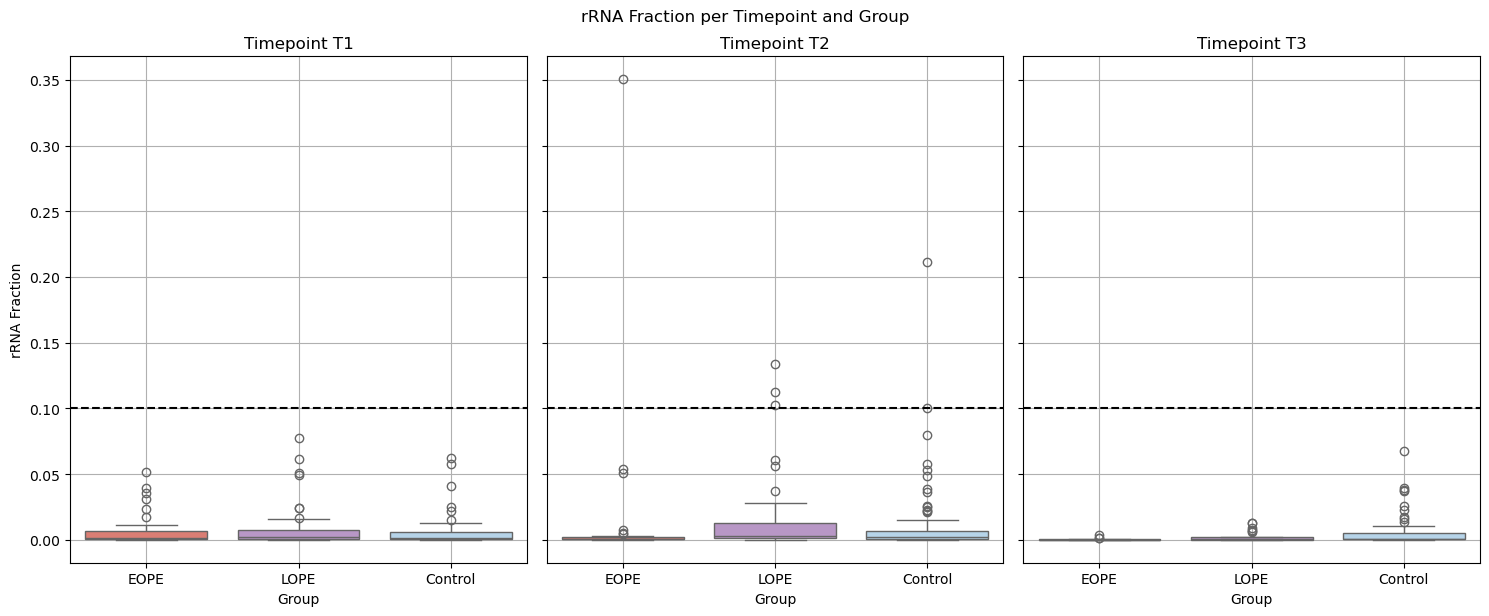

In [78]:
import warnings
warnings.filterwarnings("ignore")

# Asume que los tiempos (T1, T2, T3) están presentes en el nombre de la muestra
timepoints = ['T1', 'T2', 'T3']

# Ruta base donde están los diferentes runs
base_folder = "/home/iperez/Documents/Projects/Preeclampsia/Data/data_v45"

runs = os.listdir(base_folder)
runs.remove("MOM-PO02")

# Inicializar un DataFrame para almacenar todos los resultados
all_rRNA_results = pd.DataFrame(columns=['sample', 'timepoint', 'group', 'rRNA_fraction', 'run'])

# Iterar sobre todos los directorios en la carpeta base (que son los runs)
for run_folder in tqdm(runs):
    run_path = os.path.join(base_folder, run_folder)
    
    if os.path.isdir(run_path):
        print(f"Procesando run: {run_folder}")
        
        # Definir las rutas para los archivos de cuenta duplicada y sin duplicados
        folder_dup = os.path.join(run_path, "counts/")
        folder_dedup = os.path.join(run_path, "counts_dedup/")
        
        # Usar la función build_counts_matrix para obtener las cuentas duplicadas y sin duplicados
        dupCounts = build_counts_matrix.build_counts_matrix(folder_dup, sample_pattern=r".*-T[0-9]*")
        dedupCounts = build_counts_matrix.build_counts_matrix(folder_dedup, sample_pattern=r".*-T[0-9]*")
        
        # Convertir "GeneID" en el índice (equivalente a column_to_rownames en R)
        dupCounts.set_index("GeneID", inplace=True)
        dedupCounts.set_index("GeneID", inplace=True)
        
        # Leer el archivo 'biotypes.txt' (ruta fija de este archivo)
        gtfDatabase = pd.read_csv("/home/iperez/Documents/Projects/Preeclampsia/Data/v45biotypes.txt", sep="\t")
        gtfDatabase['GeneID'] = gtfDatabase['gene_name'].fillna(gtfDatabase['gene_ID'])
        
        # Combinar dedupCounts con gtfDatabase en base a 'GeneID'
        biotype_df = dedupCounts.merge(gtfDatabase, left_on='GeneID', right_on='GeneID', how='left')
        
        # Inicializar un DataFrame vacío para los resultados de este run
        plot_df = pd.DataFrame(columns=["gene_type", "counts", "sample", "freq", "label"])

        # Procesar cada muestra en dedupCounts
        samples = dedupCounts.columns.tolist()
        
        for s in samples:
            rows2add = (
                biotype_df[['gene_name', s, 'gene_type']]
                .rename(columns={s: 'sample_counts'})
                .groupby('gene_type')['sample_counts'].sum().reset_index()
                .assign(freq=lambda x: round(x['sample_counts'] / x['sample_counts'].sum(), 3))
                .sort_values(by='freq', ascending=False)
                .assign(label=lambda x: (x['freq'] * 100).astype(str) + '%', sample=s)
            )
            plot_df = pd.concat([plot_df, rows2add], ignore_index=True)
        
        # Filtrar por los tipos de rRNA
        plot_df['gene_type'] = plot_df['gene_type'].apply(lambda x: 'rRNA' if x in ["Mt_rRNA", "rRNA_pseudogene", "rRNA"] else 'non_rRNA')

        # Agrupar por muestra y tipo de gen, sumando las cuentas
        rRNA_plot = plot_df.groupby(['sample', 'gene_type']).agg({'sample_counts': 'sum'}).reset_index()

        # Calcular la frecuencia
        rRNA_plot = rRNA_plot.groupby('sample').apply(
            lambda x: x.assign(freq=round(x['sample_counts'] / x['sample_counts'].sum(), 6))
        ).reset_index(drop=True)

        # Filtrar solo la fracción de rRNA
        rRNA_plot = rRNA_plot[rRNA_plot['gene_type'] == 'rRNA']

        # Ahora iterar sobre los grupos (EOPE, LOPE, Control) y los tiempos
        for group, samples_group in dict_types_samples.items():
            for sample in samples_group:
                # Extraer la base del nombre de la muestra sin el sufijo '-Tn'
                sample_base = sample.split('-')[0] + "-" + sample.split('-')[1]
                
                # Buscar las muestras correspondientes en rRNA_plot para T1, T2 y T3
                for timepoint in timepoints:
                    sample_with_timepoint = f"{sample_base}-{timepoint}"
                    
                    if sample_with_timepoint in rRNA_plot['sample'].values:
                        # Filtrar los datos de rRNA para la muestra actual y el tiempo
                        sample_data = rRNA_plot[rRNA_plot['sample'] == sample_with_timepoint]
                        
                        if not sample_data.empty:
                            rRNA_fraction = sample_data['freq'].values[0]
                        else:
                            rRNA_fraction = 0.0
                        
                        # Agregar los resultados al DataFrame global
                        new_row = pd.DataFrame({
                            'sample': [sample_with_timepoint],
                            'timepoint': [timepoint],
                            'group': [group],
                            'rRNA_fraction': [rRNA_fraction],
                            'run': [run_folder]
                        })

                        all_rRNA_results = pd.concat([all_rRNA_results, new_row], ignore_index=True)

# Imprimir las muestras que superan el umbral de rRNA fracción > 0.1
threshold = 0.1
samples_above_threshold = all_rRNA_results[all_rRNA_results['rRNA_fraction'] > threshold]
print(f"Muestras que superan el umbral de {threshold}:")
print(samples_above_threshold[['sample', 'timepoint', 'group', 'rRNA_fraction']])

# Definir la paleta de colores personalizada
custom_palette = {
    "Control": "#AED6F1",  # Azul
    "EOPE": "#EC7063",  # Rojo
    "LOPE": "#BB8FCE"  # Violeta
}

# Asegurar que los grupos estén siempre en el mismo orden: LOPE, EOPE, Control
all_rRNA_results['group'] = pd.Categorical(all_rRNA_results['group'], categories=['EOPE', 'LOPE', 'Control'], ordered=True)

# Generar gráficos sin stripplot
fig, axes = plt.subplots(1, len(timepoints), figsize=(15, 6), sharey=True)

for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    sns.boxplot(x='group', y='rRNA_fraction', data=all_rRNA_results[all_rRNA_results['timepoint'] == timepoint], ax=ax, palette=custom_palette)
    ax.axhline(0.1, ls='--', color='black')  # Línea para la fracción de rRNA 0.1
    ax.set_title(f'Timepoint {timepoint}')
    ax.set_xlabel('Group')
    if i == 0:
        ax.set_ylabel('rRNA Fraction')
    else:
        ax.set_ylabel('')
    ax.grid()

plt.tight_layout()
plt.suptitle('rRNA Fraction per Timepoint and Group', y=1.02)
plt.show()

# Figure DNA contamination

100%|██████████| 27/27 [00:00<00:00, 52.22it/s]


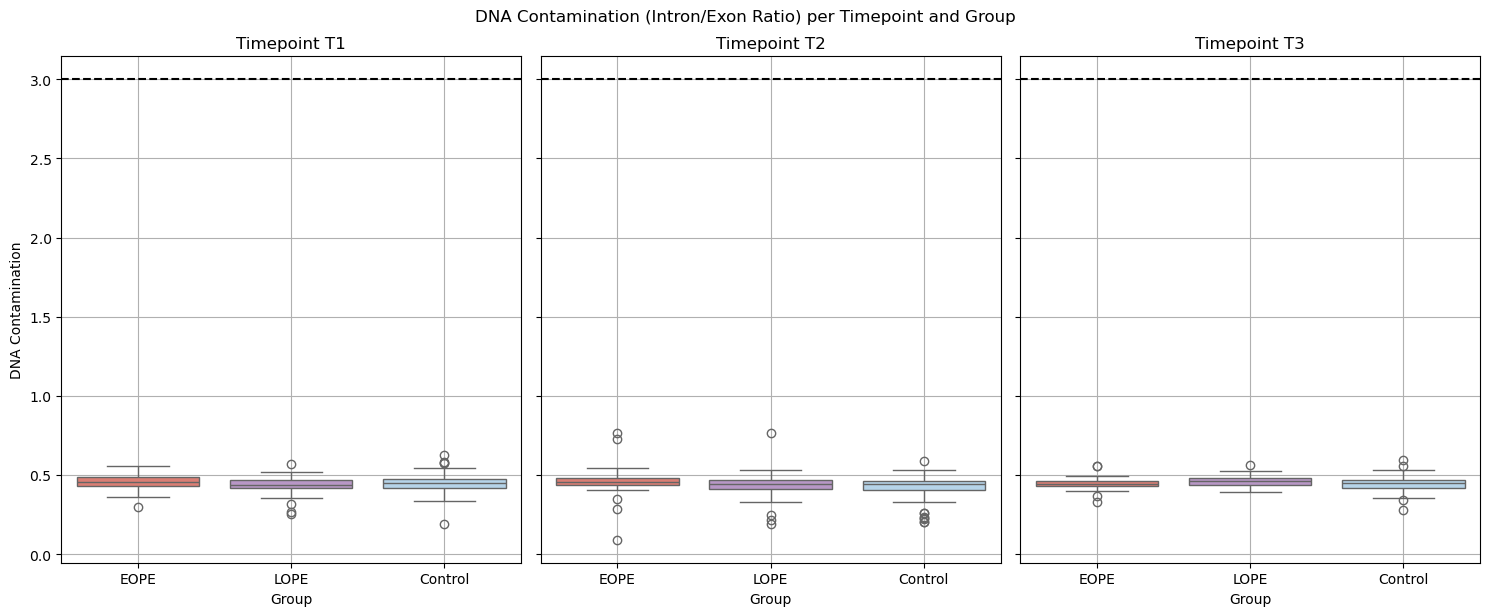

In [ ]:
# Define the list of timepoints T1, T2, T3
timepoints = ['T1', 'T2', 'T3']

# Base path where the different folders are located
base_folder = "/home/iperez/Documents/Projects/Preeclampsia/Data/data_v45"
folds = os.listdir(base_folder)
folds.remove("MOM-PO02")  # Exclude specific folders if necessary

# Initialize a DataFrame to store all results
all_contamination_metrics = pd.DataFrame(columns=['sample', 'timepoint', 'group', 'intronExonRatio', 'run'])

# Iterate over RUN-X folders
for fold in tqdm(folds):
    run_path = os.path.join(base_folder, fold)
    metrics_file = os.path.join(run_path, "multiqc_data/multiqc_rseqc_read_distribution.txt")

    # Check if the read distribution file exists
    if os.path.isfile(metrics_file):
        # Read the read distribution metrics file
        distribution_metrics = pd.read_csv(metrics_file, sep="\t")

        # Filter samples that contain "RSeQC"
        distribution_metrics = distribution_metrics[distribution_metrics['Sample'].str.contains("RSeQC")]

        # Extract sample names (removing the '_RSeQC...' suffix)
        distribution_metrics['sample'] = distribution_metrics['Sample'].apply(lambda x: re.sub(r'_RSeQC.*', '', x))

        # Calculate necessary columns
        distribution_metrics['allExons'] = (
            distribution_metrics['cds_exons_tag_count'] + 
            distribution_metrics['5_utr_exons_tag_count'] + 
            distribution_metrics['3_utr_exons_tag_count']
        )
        distribution_metrics['intronExonRatio'] = distribution_metrics['introns_tag_count'] / distribution_metrics['allExons']

        # Select relevant columns
        distribution_metrics = distribution_metrics[['sample', 'intronExonRatio']]

        # Iterate over groups (EOPE, LOPE, Control) and timepoints
        for group, samples_group in dict_types_samples.items():
            for sample in samples_group:
                # Extract the base name of the sample without the '-Tn' suffix
                sample_base = sample.split('-')[0] + "-" + sample.split('-')[1]
                
                # Find corresponding samples in distribution_metrics for T1, T2, and T3
                for timepoint in timepoints:
                    sample_with_timepoint = f"{sample_base}-{timepoint}"
                    
                    if sample_with_timepoint in distribution_metrics['sample'].values:
                        # Filter contamination data for the current sample and timepoint
                        sample_data = distribution_metrics[distribution_metrics['sample'] == sample_with_timepoint]
                        
                        if not sample_data.empty:
                            intronExonRatio = sample_data['intronExonRatio'].values[0]
                        else:
                            intronExonRatio = 0.0
                        
                        # Add results to the global DataFrame
                        new_row = pd.DataFrame({
                            'sample': [sample_with_timepoint],
                            'timepoint': [timepoint],
                            'group': [group],
                            'intronExonRatio': [intronExonRatio],
                            'run': [fold]
                        })

                        all_contamination_metrics = pd.concat([all_contamination_metrics, new_row], ignore_index=True)

# Define a custom color palette
custom_palette = {
    "Control": "#AED6F1",  # Blue
    "EOPE": "#EC7063",  # Red
    "LOPE": "#BB8FCE"  # Purple
}

# Ensure groups are always in the same order: EOPE, LOPE, Control
all_contamination_metrics['group'] = pd.Categorical(all_contamination_metrics['group'], categories=["EOPE", 'LOPE', 'Control'], ordered=True)

# Generate plots for DNA Contamination (Intron/Exon Ratio)
fig, axes = plt.subplots(1, len(timepoints), figsize=(15, 6), sharey=True)

for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    sns.boxplot(x='group', y='intronExonRatio', data=all_contamination_metrics[all_contamination_metrics['timepoint'] == timepoint], ax=ax, palette=custom_palette)
    ax.axhline(3, ls='--', color='black')  # Reference line at y=3 for DNA contamination
    ax.set_title(f'Timepoint {timepoint}')
    ax.set_xlabel('Group')
    if i == 0:
        ax.set_ylabel('DNA Contamination')
    else:
        ax.set_ylabel('')
    ax.grid()

plt.tight_layout()
plt.suptitle('DNA Contamination (Intron/Exon Ratio) per Timepoint and Group', y=1.02)
plt.show()


# Figure RNA contamination

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:00<00:00, 55.39it/s]


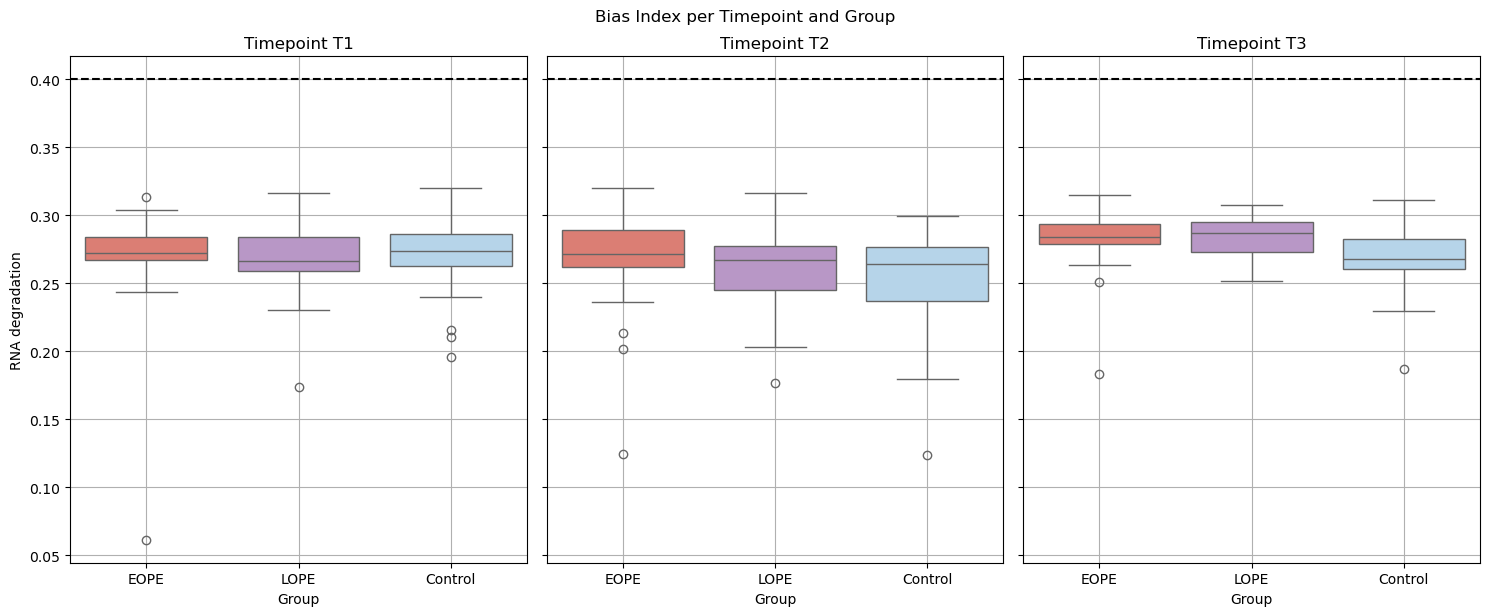

In [ ]:
# Define the list of timepoints T1, T2, T3
timepoints = ['T1', 'T2', 'T3']

# Define the groups: LOPE, EOPE, and Control
dict_types_samples = {
    "LOPE": LOPE_samples,   # Define this list for LOPE samples
    "EOPE": EOPE_samples,   # Define this list for EOPE samples
    "Control": control_samples  # Define this list for Control samples
}

# Base path where the different folders are located
base_folder = "/home/iperez/Documents/Projects/Preeclampsia/Data/data_v45"
folds = os.listdir(base_folder)
folds.remove("MOM-PO02")  # Exclude specific folders if necessary

# Initialize a DataFrame to store all results
all_bias_indices = pd.DataFrame(columns=['sample', 'timepoint', 'group', 'biasIndex', 'run'])

# Iterate over RUN-X folders
for fold in tqdm(folds):
    run_path = os.path.join(base_folder, fold)
    metrics_file = os.path.join(run_path, "3primebias_metrics.txt")

    # Check if the 3primebias_metrics file exists
    if os.path.isfile(metrics_file):
        # Read the metrics file
        distribution_metrics = pd.read_csv(metrics_file, sep="\t")

        # Add RUN information to help with tracking
        distribution_metrics["RUN"] = fold

        # Select relevant columns and rename if necessary
        distribution_metrics = distribution_metrics[['sample', 'biasIndex']]

        # Iterate over groups (EOPE, LOPE, Control) and timepoints
        for group, samples_group in dict_types_samples.items():
            for sample in samples_group:
                # Extract the base sample name without the '-Tn' suffix
                sample_base = sample.split('-')[0] + "-" + sample.split('-')[1]
                
                # Look for corresponding samples in distribution_metrics for T1, T2, and T3
                for timepoint in timepoints:
                    sample_with_timepoint = f"{sample_base}-{timepoint}"
                    
                    if sample_with_timepoint in distribution_metrics['sample'].values:
                        # Filter biasIndex data for the current sample and timepoint
                        sample_data = distribution_metrics[distribution_metrics['sample'] == sample_with_timepoint]
                        
                        if not sample_data.empty:
                            biasIndex = sample_data['biasIndex'].values[0]
                        else:
                            biasIndex = 0.0
                        
                        # Add results to the global DataFrame
                        new_row = pd.DataFrame({
                            'sample': [sample_with_timepoint],
                            'timepoint': [timepoint],
                            'group': [group],
                            'biasIndex': [biasIndex],
                            'run': [fold]
                        })

                        all_bias_indices = pd.concat([all_bias_indices, new_row], ignore_index=True)

# Define a custom color palette
custom_palette = {
    "Control": "#AED6F1",  # Blue
    "EOPE": "#EC7063",  # Red
    "LOPE": "#BB8FCE"  # Purple
}

# Ensure groups are always in the same order: EOPE, LOPE, Control
all_bias_indices['group'] = pd.Categorical(all_bias_indices['group'], categories=['EOPE', 'LOPE', 'Control'], ordered=True)

# Generate plots for biasIndex
fig, axes = plt.subplots(1, len(timepoints), figsize=(15, 6), sharey=True)

for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    sns.boxplot(x='group', y='biasIndex', data=all_bias_indices[all_bias_indices['timepoint'] == timepoint], ax=ax, palette=custom_palette)
    ax.axhline(0.4, ls='--', color='black')  # Reference line if needed
    ax.set_title(f'Timepoint {timepoint}')
    ax.set_xlabel('Group')
    if i == 0:
        ax.set_ylabel('RNA degradation')
    else:
        ax.set_ylabel('')
    ax.grid()

plt.tight_layout()
plt.suptitle('Bias Index per Timepoint and Group', y=1.02)
plt.show()

# Build cm and metadata

In [20]:
# Define the base folder for all runs
base_folder = "/home/iperez/Documents/Projects/Preeclampsia/Data/data_v45"  # Set the correct path
sample_type = "T1"  # Set this to T1, T2, or T3 based on which samples you want to analyze
type_PE = "EOPE"

folds = os.listdir(base_folder)
folds.remove('MOM-PO02')

In [ ]:
# Initialize lists to store counts
all_counts = []
all_dedup_counts = []

# Iterate over each run folder
for fold in tqdm(folds):
    path_counts = base_folder + f"/{fold}/counts/"
    path_counts_dedup = base_folder + f"/{fold}/counts_dedup/"

    RUN = fold  # Current RUN

    # Use the build_counts_matrix function to get duplicate counts
    dupCounts = build_counts_matrix.build_counts_matrix(path_counts, sample_pattern=r".*-T[0-9]*")

    # Set "GeneID" column as index (equivalent to column_to_rownames in R)
    dupCounts.set_index("GeneID", inplace=True)

    # Create `run` and `samples` variables
    run = [RUN] * dupCounts.shape[1]  # Repeat RUN for the number of columns in dupCounts
    samples = dupCounts.columns.tolist()

    # Use the build_counts_matrix function to get deduplicated counts
    dedupCounts = build_counts_matrix.build_counts_matrix(path_counts_dedup, sample_pattern=r".*-T[0-9]*")

    # Set "GeneID" column as index (equivalent to column_to_rownames in R)
    dedupCounts.set_index("GeneID", inplace=True)

    # Calculate the difference between duplicate and deduplicated counts
    diffDups = dupCounts - dedupCounts

    # Filter to include only T1 samples
    dupCounts = dupCounts.T[dupCounts.T.index.str.contains("T1")]
    dedupCounts = dedupCounts.T[dedupCounts.T.index.str.contains("T1")]

    # Append to the global lists
    all_counts.append(dupCounts)
    all_dedup_counts.append(dedupCounts)

# Combine all counts into a single DataFrame
all_counts = pd.concat(all_counts)
all_dedup_counts = pd.concat(all_dedup_counts)

# Filter by LOPE, EOPE, or CONTROL
# Update indices to standard format (remove timepoint suffix)
all_dedup_counts.index = [x.split("-")[0] + "-" + x.split("-")[1] for x in all_dedup_counts.index]
all_dedup_counts_filt = all_dedup_counts[all_dedup_counts.index.isin(dict_types_samples[type_PE])]

all_counts.index = [x.split("-")[0] + "-" + x.split("-")[1] for x in all_counts.index]
all_counts_filt = all_counts[all_counts.index.isin(LOPE_samples)]


In [ ]:
# Read the metadata CSV file
metadata = pd.read_csv("./CRD_finalizado_allsamples_20241003.csv", delimiter=';', index_col=0)  

# Shift all columns one position to the right (specific to the updated metadata format from 03/10/2024)
metadata = metadata.shift(axis=1)

# Filter metadata to match the columns in dedupCounts
metadata_filtered = metadata[metadata['Código paciente'].isin(
    [re.sub(r'-T[1-3]?A?', '', col) for col in dedupCounts.columns]
)]

# Create new calculated columns
metadata_filtered = metadata_filtered.assign(
    group=metadata_filtered['C.O. Preeclampsia fin estudio'].fillna("No"),  # Assign "No" to NaN values
    EGM1=(metadata_filtered['Edad gestacional semanas muestra 1'] * 7) + metadata_filtered['Edad gestacional días muestra 1'],  # Convert weeks + days to days
    EGM2=(metadata_filtered['Edad gestacional semanas muestra 2'] * 7) + metadata_filtered['Edad gestacional días muestra 2'],
    EGM3=(metadata_filtered['Edad gestacional semanas muestra 3'] * 7) + metadata_filtered['Edad gestacional días muestra 3'],
    age=pd.to_numeric(metadata_filtered['Edad'], errors='coerce'),  # Convert age to numeric, handling errors
    BMI=pd.to_numeric(metadata_filtered['IMC'], errors='coerce'),  # Convert BMI to numeric, handling errors
    etnicity=metadata_filtered['Grupo étnico'],  # Assign ethnicity
    nuliparity=metadata_filtered['Nuliparidad'],  # Assign nulliparity
    patient=metadata_filtered['Código paciente']  # Assign patient code
)

# Select only the necessary columns
metadata_filtered = metadata_filtered[['patient', 'age', 'BMI', 'etnicity', 'nuliparity', 'EGM1', 'EGM2', 'EGM3', 'group']]

# Create a new DataFrame (metadataDF) using the columns from dedupCounts
metadataDF = pd.DataFrame({'sample': dedupCounts.columns})

# Add 'patient' and 'toma' (sample collection) columns using regex
metadataDF['patient'] = metadataDF['sample'].apply(lambda x: re.sub(r'-T.*', '', x))  # Remove timepoint suffix
metadataDF['toma'] = metadataDF['sample'].apply(lambda x: re.sub(r'C[0-9]*-P[0-9]*-', '', x))  # Extract sample collection info

# Perform a join between metadataDF and metadata_filtered
metadataDF = metadataDF.merge(metadata_filtered, on='patient', how='left')

# Calculate the 'EGM' column based on the sample collection timepoint
metadataDF['EGM'] = metadataDF.apply(
    lambda row: row['EGM1'] if row['toma'] == 'T1' else 
                (row['EGM2'] if row['toma'] == 'T2' else row['EGM3']), axis=1
)

# Select the final columns and replace values in the 'group' column
metadataDF = metadataDF[['sample', 'patient', 'toma', 'age', 'BMI', 'etnicity', 'nuliparity', 'EGM', 'group']]
metadataDF['group'] = metadataDF['group'].replace({'No': 'Control', 'PE': 'PE'})  # Replace 'No' with 'Control'

# Final adjustments for the 'group' column
metadataDF['group'] = metadataDF['group'].replace(1, 'PE')  # Replace 1 with 'PE'
metadataDF['group'] = metadataDF['group'].replace(0, 'Control')  # Replace 0 with 'Control'

# Display the resulting metadata DataFrame
metadataDF.head()


/tmp/ipykernel_3187913/2605269040.py:5: DtypeWarning: Columns (19,23,106,139,193,198,214,216,260,261,262,263,267,271,322,397,398,399,403,407,429,452) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("./CRD_finalizado_allsamples_20241003.csv", delimiter=';', index_col = 0)  # CRD_finalizado_allsamples_20241003   CRD_finalizado_allsamples_20240402


,sample,patient,toma,age,BMI,etnicity,nuliparity,EGM,group
0,5S_rRNA,5S_rRNA,5S_rRNA,NaN,NaN,NaN,NaN,NaN,NaN
1,5_8S_rRNA,5_8S_rRNA,5_8S_rRNA,NaN,NaN,NaN,NaN,NaN,NaN
2,7SK,7SK,7SK,NaN,NaN,NaN,NaN,NaN,NaN
3,A1BG,A1BG,A1BG,NaN,NaN,NaN,NaN,NaN,NaN
4,A1BG-AS1,A1BG-AS1,A1BG-AS1,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Encuentra el nombre de la columna que contiene el valor con "EOPE"
columnas_con_eope = [col for col in metadata.columns if metadata[col].astype(str).str.contains("EOPE", na=False).any()]

print("Columnas que contienen 'EOPE':", columnas_con_eope)


Columnas que contienen 'EOPE': ['Detalles adicionales cribado preeclampsia muestra 1']


# Normalized gene counts

In [ ]:
dict_types_samples = {"LOPE": LOPE_samples,
                      "EOPE": EOPE_samples,
                      "Control": control_samples}


In [59]:
paths_cms = os.listdir("/home/iperez/Documents/Projects/Preeclampsia/Data/counts/without_hemo/")
paths_cms

['limma_counts_normal_eope_ctr_t2_not_hb 1.csv',
 'limma_counts_normal_lope_ctr_t1_not_hb 1.csv',
 'limma_counts_normal_lope_ctr_t3_not_hb 1.csv',
 'limma_counts_normal_lope_ctr_t2_not_hb 1.csv',
 'limma_counts_normal_eope_ctr_t3_not_hb 1.csv',
 'limma_counts_normal_eope_ctr_t1_not_hb 1.csv']

### PCA LOPE Tn VS CONTROL

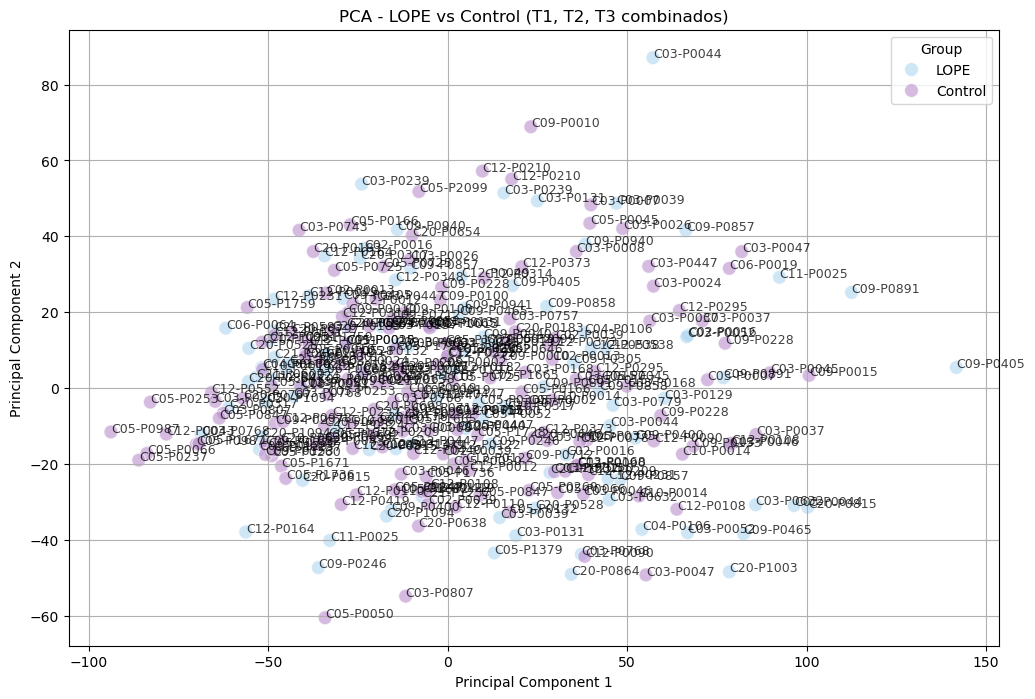

In [ ]:
# Paths to the files containing data for T1, T2, and T3
paths_cm = [
    'limma_counts_normal_lope_ctr_t1_not_hb 1.csv',
    'limma_counts_normal_lope_ctr_t2_not_hb 1.csv',
    'limma_counts_normal_lope_ctr_t3_not_hb 1.csv'
]

# Load and combine the data for T1, T2, and T3
dfs = []
for path in paths_cm:
    # Load the data and transpose it
    df_temp = pd.read_csv(f"/home/iperez/Documents/Projects/Preeclampsia/Data/counts/without_hemo/{path}", index_col=0).T
    # Extract the timepoint (T1, T2, T3) from the sample names
    df_temp['Timepoint'] = df_temp.index.str.extract(r'-(T[123])$', expand=False)
    # Remove the timepoint suffix (-Tn) to unify sample names
    df_temp.index = df_temp.index.str.replace(r'-T[123]$', '', regex=True)
    dfs.append(df_temp)

# Combine the DataFrames for T1, T2, and T3 into a single DataFrame
df_combined = pd.concat(dfs)

# Filter samples for LOPE and Control groups
df_lope = df_combined[df_combined.index.isin(dict_types_samples["LOPE"])]
df_control = df_combined[df_combined.index.isin(dict_types_samples["Control"])]

# Combine both groups into a single DataFrame for PCA
df_pca = pd.concat([df_lope, df_control]).dropna(axis=1)

# Preserve the 'Timepoint' column in a separate variable
timepoint_column = df_pca.pop('Timepoint')

# Prepare the data for PCA
X = df_pca.values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Create a DataFrame with the PCA results and group labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_pca.index)
pca_df['Group'] = ['LOPE' if sample in dict_types_samples["LOPE"] else 'Control' for sample in pca_df.index]

# Add the 'Timepoint' column back to pca_df
pca_df['Timepoint'] = timepoint_column.values

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Group', 
    data=pca_df, 
    palette={'LOPE': '#AED6F1', 'Control': '#BB8FCE'}, 
    s=100, 
    alpha=0.6
)
plt.title("PCA - LOPE vs Control (T1, T2, T3 combined)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Group")
plt.grid(True)

# Add the name of each sample to the plot
for i, sample in enumerate(pca_df.index):
    plt.text(pca_df['PC1'][i] + 0.02, pca_df['PC2'][i], sample, fontsize=9, alpha=0.75)

plt.show()


In [73]:
pca_df.to_csv("pca_lope_control.csv")

### PCA all Tn EOPE VS CONTROL

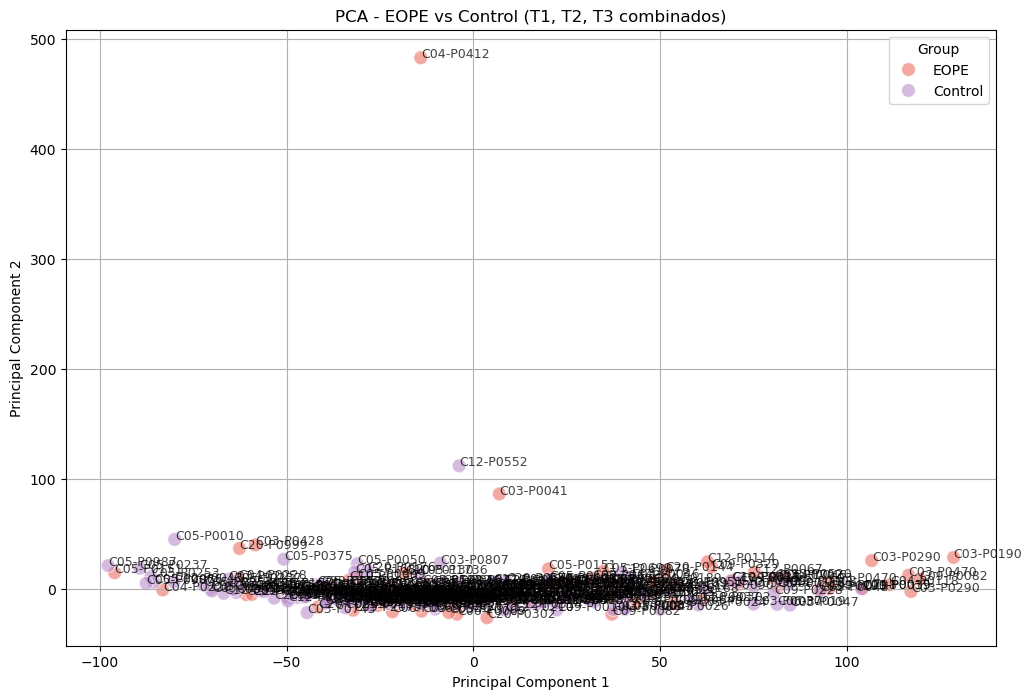

In [ ]:
# Paths to the files containing data for T1, T2, and T3
paths_cm = [
    'limma_counts_normal_eope_ctr_t1_not_hb 1.csv',
    'limma_counts_normal_eope_ctr_t2_not_hb 1.csv',
    'limma_counts_normal_eope_ctr_t3_not_hb 1.csv'
]

# Load and combine the data for T1, T2, and T3
dfs = []
for path in paths_cm:
    # Load the data and transpose it
    df_temp = pd.read_csv(f"/home/iperez/Documents/Projects/Preeclampsia/Data/counts/without_hemo/{path}", index_col=0).T
    # Extract the timepoint (T1, T2, T3) from the sample names
    df_temp['Timepoint'] = df_temp.index.str.extract(r'-(T[123])$', expand=False)
    # Remove the timepoint suffix (-Tn) to unify sample names
    df_temp.index = df_temp.index.str.replace(r'-T[123]$', '', regex=True)
    dfs.append(df_temp)

# Combine the DataFrames for T1, T2, and T3 into a single DataFrame
df_combined = pd.concat(dfs)

# Filter samples for EOPE and Control groups
df_eope = df_combined[df_combined.index.isin(dict_types_samples["EOPE"])]
df_control = df_combined[df_combined.index.isin(dict_types_samples["Control"])]

# Combine both groups into a single DataFrame for PCA
df_pca = pd.concat([df_eope, df_control]).dropna(axis=1)

# Preserve the 'Timepoint' column in a separate variable
timepoint_column = df_pca.pop('Timepoint')

# Prepare the data for PCA
X = df_pca.values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Create a DataFrame with the PCA results and group labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=df_pca.index)
pca_df['Group'] = ['EOPE' if sample in dict_types_samples["EOPE"] else 'Control' for sample in pca_df.index]

# Add the 'Timepoint' column back to pca_df
pca_df['Timepoint'] = timepoint_column.values

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Group', 
    data=pca_df, 
    palette={'EOPE': '#EC7063', 'Control': '#BB8FCE'}, 
    s=100, 
    alpha=0.6
)
plt.title("PCA - EOPE vs Control (T1, T2, T3 combined)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Group")
plt.grid(True)

# Add the name of each sample to the plot
for i, sample in enumerate(pca_df.index):
    plt.text(pca_df['PC1'][i] + 0.02, pca_df['PC2'][i], sample, fontsize=9, alpha=0.75)

plt.show()


In [76]:
pca_df.to_csv("pca_eope_control.csv")

In [77]:
pca_df

,PC1,PC2,Group,Timepoint
C03-P0041,43.141347,-12.730201,EOPE,T1
C03-P0190,10.074411,-9.842519,EOPE,T1
C03-P0290,92.367211,-0.397388,EOPE,T1
C03-P0356,41.993937,-5.336786,EOPE,T1
C03-P0428,21.795710,-12.345623,EOPE,T1
...,...,...,...,...
C20-P0183,-32.234234,-9.726514,Control,T3
C20-P0646,8.191406,5.015061,Control,T3
C20-P0654,11.384333,-2.996390,Control,T3
C20-P0698,19.880309,7.244791,Control,T3
